# RBIG Demo

In [ ]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import corner

In [3]:
ntrain = 10_000
nvalid = 5_000
ntest = 10_000
nplot = 1_000_000
noise = 0.1
random_state = 123
train_data = make_moons(n_samples=ntrain, noise=noise, random_state=random_state)[0]
val_data = make_moons(n_samples=nvalid, noise=noise, random_state=random_state)[0]
test_data = make_moons(n_samples=ntest, noise=noise, random_state=random_state*10)[0]
plot_data = make_moons(n_samples=nplot, noise=noise, random_state=random_state*10)[0]

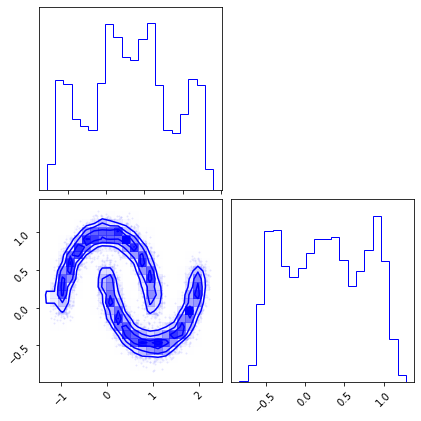

In [4]:
fig = plt.figure(figsize=(7, 7))

corner.corner(train_data, color="blue", fig=fig)

plt.show()

In [5]:
from rbig._src.uniform import MarginalHistogramUniformization
from rbig._src.invcdf import InverseGaussCDF
from rbig._src.rotation import PCARotation
from rbig._src.losses import negative_log_likelihood
from rbig._src.total_corr import information_reduction
from rbig._src.training import train_rbig_info_loss
from tqdm.notebook import trange
import numpy as np

2021-10-16 23:28:47,923: INFO: Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-10-16 23:28:47,923: INFO: NumExpr defaulting to 8 threads.


In [20]:
gf_model = train_rbig_info_loss(train_data, max_layers=1_000, zero_tolerance=10)


Info Red: 0.0000:  74%|███████▍  | 745/1000 [00:23<00:08, 31.24it/s]


KeyboardInterrupt: 

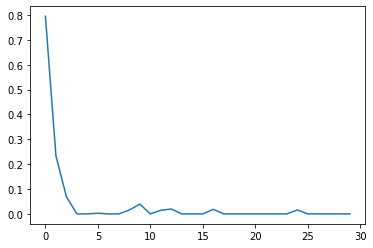

In [17]:
plt.plot(gf_model.info_loss)

In [18]:
Xg = gf_model.forward(train_data)

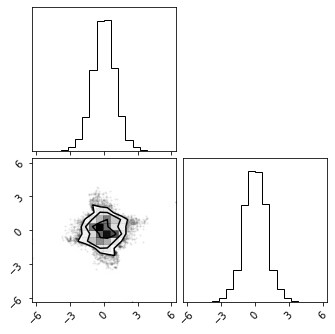

In [19]:
fig = corner.corner(Xg)


In [ ]:
X_train = train_data.copy()
# X_train += 0.1 * np.random.rand(*X_train.shape)
X_valid = val_data.copy()
X_ldj_train = np.zeros(X_train.shape[0])
X_ldj_valid = np.zeros(X_valid.shape[0])

n_layers = 25
alpha = 0.98
transformations = []
train_losses, valid_losses = [], []
info_train_losses, info_valid_losses = [], []

with trange(n_layers) as pbar:
    for ilayer in pbar:
    
        X_train_before = X_train.copy()
        X_valid_before = X_valid.copy()

        # marginal uniformization
        ibijector = MarginalHistogramUniformization(X=X_train, bound_ext=0.3, bins="auto", alpha=1e-10)
#         ibijector = MarginalKDEUniformization(X=X_train, bound_ext=0.3, fft=False, n_quantiles=50, grid_size=100)
        transformations.append(ibijector)
        # train data
        X_ldj_train += ibijector.gradient(X_train)
        X_train = ibijector.forward(X_train)
        # valid data
        X_ldj_valid += ibijector.gradient(X_valid)
        X_valid = ibijector.forward(X_valid)

        

        # inverse cdf transformation
        ibijector = InverseGaussCDF(1e-7)
        # save bijector
        transformations.append(ibijector)
        # train data
        X_ldj_train += ibijector.gradient(X_train)
        X_train = ibijector.forward(X_train)
        # valid data
        X_ldj_valid += ibijector.gradient(X_valid)
        X_valid = ibijector.forward(X_valid)

        # rotation
        ibijector = PCARotation(X=X_train)
        # save bijector
        transformations.append(ibijector)
        # train data
        X_ldj_train += ibijector.gradient(X_train)
        X_train = ibijector.forward(X_train)
        # valid data
        X_ldj_valid += ibijector.gradient(X_valid)
        X_valid = ibijector.forward(X_valid)

            
        # calculate the loss
        loss_train = negative_log_likelihood(X_train, X_ldj_train)
        loss_valid = negative_log_likelihood(X_valid, X_ldj_valid)
        # k2, p = stats.normaltest(X_valid, axis=None)
        # neg_ent = neg_entropy_normal(X_valid)
        

        X_train_after = X_train.copy()
        X_valid_after = X_valid.copy()

        info_red_train = information_reduction(X_train_before, X_train_after)
        info_red_valid = information_reduction(X_valid_before, X_valid_after)
        
            
        pbar.set_description(f"Loss (Train): {loss_train:.4f} | Loss (Valid): {loss_valid:.4f} | Info Red (Train): {info_red_train:.4f} | Info Red (Valid): {info_red_valid:.4f}")
        
        train_losses.append(loss_train)
        valid_losses.append(loss_valid)
        info_train_losses.append(info_red_train)
        info_valid_losses.append(info_red_valid)


In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses)
ax.plot(valid_losses)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(info_train_losses)
ax.plot(info_valid_losses)
plt.show()